<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/PCam_80k_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Data is a modified version of the PCam dataset--duplicates have been removed. The goal is to classify the images as cancerous or non-cancerous. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
https://www.kaggle.com/c/histopathologic-cancer-detection/data?select=train_labels.csv 

###Acknowledgements
Code was adapted from the following sources:

Deep Learning with Python by Francis Chollet

https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch


#Setup and Preprocessing

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
#%matplotlib inline
#sns.set(style="whitegrid")

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import os, random
from random import shuffle
import cv2 #image processing
from glob import glob #for easily finding matching filenames 
from tqdm import tqdm, tqdm_notebook, trange #progress bar
import gc #garbage collection, for saving RAM

import tensorflow as tf
from tensorflow import keras
keras.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0-tf'

In [2]:
from keras import metrics
from keras import models
from keras import layers

Using TensorFlow backend.


##Upload data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Code executed once to unzip the files, then commented out:

In [0]:
# #unzip set of training files (smaller dataset to make sure it works)
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/sampleTrain.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain"

In [4]:
#Check whether sample files are readable
sample_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain/sampleTrain')
print(f'{len(sample_names)} files in sample directory')
print(sample_names[:5])

10 files in sample directory
['00a0ad1de2cdf805f02c524a985bca5bce1d1b5f.tif', '0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif', '0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif', '0a0d1a09e5cf9fcc308ecdc210450aecd204d344.tif', '0a0b4604d66cecfe668e26383c22fafb74484eef.tif']


Started with 10,000 training files in order develop model

Be sure to change path below when adding more files

In [0]:
# #unzip set of training files
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/train80.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/train"

In [0]:
# drive.mount("/content/drive", force_remount=True)

In [7]:
#Check whether sample files are readable
train_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/train/train80')
print(f'{len(train_names)} files in training directory')
print(train_names[:5])

80000 files in training directory
['6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0.tif', '9c043ab2adadfeb758c71d21432fccd3e43565c0.tif', '9cc775713dd09351172a350871a547346af08027.tif', '1c1b9b8dc88097d7df41ca9a24111359fd44a57d.tif', '7e45df9e3833b03a4491ef04de755bb04623ab6d.tif']


Code below to unzip testing data. It has not been run yet it order to save space on Drive.

In [0]:
# #unzip set of testing files 
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/test.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/test"

In [0]:
# #Check whether sample files are readable
# test_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/test')
# print(f'{len(test_names)} files in testing directory')
# print(test_names[:5])

##Set paths

In [0]:
path = '/content/drive/My Drive/MSDS 458/PCam/unzipped/'
train_path = path+'train/train80'
test_path =  path+'test/'
sample_path = path+'sampleTrain/sampleTrain'  #contains 10 images, simply for testing data can be read

##Load labels and filenames

In [0]:
labels = pd.read_csv('/content/drive/My Drive/MSDS 458/PCam/train_labels.csv')

In [10]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[9].split(".")[0]) # keep only the file names in 'id'
df.head()

,path,id
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9c043ab2adadfeb758c71d21432fccd3e43565c0
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9cc775713dd09351172a350871a547346af08027
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,1c1b9b8dc88097d7df41ca9a24111359fd44a57d
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,7e45df9e3833b03a4491ef04de755bb04623ab6d


In [0]:
df = df.merge(labels, on = "id") # merge labels and filepaths

In [12]:
df.head(5) # print the first five entries

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0,0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9c043ab2adadfeb758c71d21432fccd3e43565c0,1
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9cc775713dd09351172a350871a547346af08027,0
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,1c1b9b8dc88097d7df41ca9a24111359fd44a57d,1
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,7e45df9e3833b03a4491ef04de755bb04623ab6d,0


In [13]:
print(df.count) #check total number of rows in dataframe

<bound method DataFrame.count of                                                     path  ... label
0      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
1      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
2      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
3      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
4      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
...                                                  ...  ...   ...
79995  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
79996  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
79997  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
79998  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
79999  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1

[80000 rows x 3 columns]>


##Load images

In [0]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    dfLabel=df['label']
    y = np.squeeze(dfLabel.to_numpy())[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])

    # Scale the data to [0,1] interval
    X = X.astype('float16')/255      
    return X,y

In [15]:
# Load some of the images
N=1000
X,y = load_data(N=N,df=df) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: ignored

##EDA

View some sample images. Non-cancerous samples are labeled 0, and cancerous samples are labeled 1.

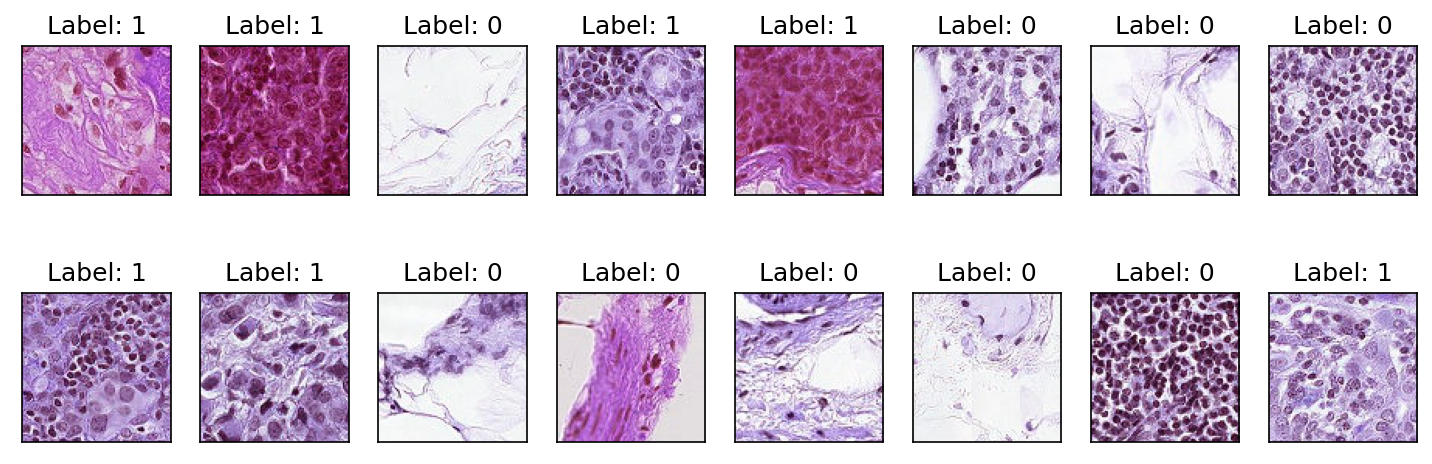

In [40]:
fig = plt.figure(figsize=(12, 4), dpi=150)
np.random.seed(777) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,16)):
    ax = fig.add_subplot(2, 16//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

Evaluate the distribution of the two classes

Text(0, 0.5, 'Samples')

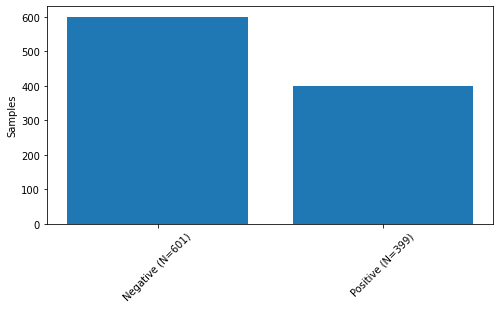

In [24]:
plt.figure(figsize=[8,4])
plt.bar([0,1], [(y==0).sum(), (y==1).sum()])
plt.axis()
plt.xticks([0,1],[f"Negative (N={(y==0).sum()})",f"Positive (N={(y==1).sum()})"],rotation=45)
#plt.xticks(rotation=45)
#plt.rc('xtick',labelsize=10)
plt.ylabel('Samples')


In [25]:
print(f"{round((y==1).sum()/len(y)*100,2)}% of the samples are positive.") 
print(f"We need to clear the baseline of {round((y==0).sum()/len(y)*100,2)}%, which would be the accuracy if we predicted that all of the samples were non-cancerous.")

39.9% of the samples are positive.
We need to clear the baseline of 60.1%, which would be the accuracy if we predicted that all of the samples were non-cancerous.


###To evaluate the classes individually

In [0]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

Look at the distribution of the pixels for each color channel

In [0]:
# nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
# fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

# #RGB channels
# axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
# axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

# #All channels
# axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
# axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

# #Set image labels
# axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
# axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
# axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
# axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
# axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
# axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
# for i in range(4):
#     axs[i,0].set_ylabel("Relative frequency")
# axs[3,0].set_xlabel("Pixel value")
# axs[3,1].set_xlabel("Pixel value")
# fig.tight_layout()

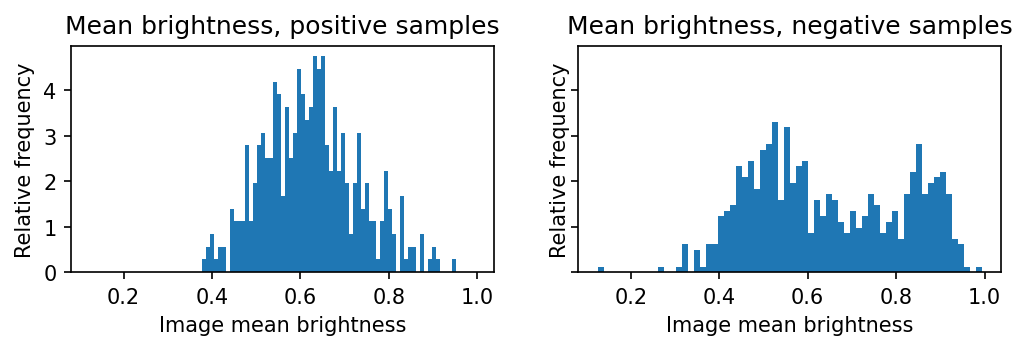

In [28]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

In [0]:
#Clean up variables to free up RAM
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

#Prepare data for modeling

In [16]:
#Load remainder of dataset
X = None
y = None
gc.collect();
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [17]:
X[2]

array([[[0.7607, 0.71  , 0.8823],
        [0.6626, 0.6157, 0.7803],
        [0.855 , 0.8   , 0.961 ],
        ...,
        [0.8076, 0.788 , 0.9136],
        [0.9414, 0.929 , 1.    ],
        [0.7256, 0.714 , 0.8394]],

       [[0.8433, 0.792 , 0.965 ],
        [0.753 , 0.6943, 0.8667],
        [0.647 , 0.5806, 0.749 ],
        ...,
        [0.718 , 0.698 , 0.8115],
        [0.8115, 0.792 , 0.9136],
        [0.639 , 0.6313, 0.749 ]],

       [[0.7725, 0.71  , 0.894 ],
        [0.6743, 0.604 , 0.788 ],
        [0.9136, 0.8354, 1.    ],
        ...,
        [0.898 , 0.8823, 0.9805],
        [0.7725, 0.757 , 0.855 ],
        [0.678 , 0.6587, 0.7646]],

       ...,

       [[0.4666, 0.3647, 0.545 ],
        [0.3215, 0.2196, 0.4   ],
        [0.718 , 0.604 , 0.796 ],
        ...,
        [0.741 , 0.686 , 0.8276],
        [0.753 , 0.698 , 0.859 ],
        [0.847 , 0.792 , 0.957 ]],

       [[0.2393, 0.0745, 0.2588],
        [0.4587, 0.2942, 0.4785],
        [0.451 , 0.2864, 0.4707],
        .

In [61]:
X[1]

array([[[0.49019608, 0.16078432, 0.46666667],
        [0.73333335, 0.42352942, 0.70980394],
        [0.9372549 , 0.65882355, 0.91764706],
        ...,
        [0.73333335, 0.45490196, 0.6745098 ],
        [0.7137255 , 0.43137255, 0.6392157 ],
        [0.7058824 , 0.42352942, 0.627451  ]],

       [[0.63529414, 0.32156864, 0.5921569 ],
        [0.9098039 , 0.6117647 , 0.8627451 ],
        [0.7372549 , 0.4627451 , 0.69803923],
        ...,
        [0.6745098 , 0.38039216, 0.6       ],
        [0.75686276, 0.4627451 , 0.68235296],
        [0.6745098 , 0.3764706 , 0.5882353 ]],

       [[0.7882353 , 0.5019608 , 0.72156864],
        [0.74509805, 0.47058824, 0.6784314 ],
        [0.47058824, 0.2       , 0.4       ],
        ...,
        [0.83137256, 0.53333336, 0.7607843 ],
        [0.7490196 , 0.4392157 , 0.6627451 ],
        [0.6862745 , 0.36862746, 0.5921569 ]],

       ...,

       [[0.5019608 , 0.2       , 0.46666667],
        [0.7372549 , 0.43529412, 0.7254902 ],
        [0.6784314 , 0

##Train test split

In [0]:
# Split into train and test (80/20)
from sklearn.model_selection import train_test_split
#not setting a random_state and not shuffling because samples are already shuffled and want to save RAM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((64000, 96, 96, 3), (16000, 96, 96, 3), (64000,), (16000,))

In [0]:
X = None
y = None
gc.collect();

#Define callbacks for training/testing times

In [0]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [0]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

#Experiment 1:DNN
Establish a baseline

##Build and compile the model

In [24]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(96, 96, 3)))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 27648)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2764900   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,765,001
Trainable params: 2,765,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [26]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 19s 342us/step - loss: 0.7391 - accuracy: 0.5943 - val_loss: 0.6372 - val_accuracy: 0.5789
Epoch 2/15
54400/54400 [==============================] - 17s 305us/step - loss: 0.6250 - accuracy: 0.6135 - val_loss: 0.6288 - val_accuracy: 0.6373
Epoch 3/15
54400/54400 [==============================] - 17s 305us/step - loss: 0.6216 - accuracy: 0.6279 - val_loss: 0.6199 - val_accuracy: 0.5850
Epoch 4/15
54400/54400 [==============================] - 17s 304us/step - loss: 0.6155 - accuracy: 0.6372 - val_loss: 0.6178 - val_accuracy: 0.5939
Epoch 5/15
54400/54400 [==============================] - 17s 304us/step - loss: 0.6103 - accuracy: 0.6515 - val_loss: 0.6142 - val_accuracy: 0.6259
Epoch 6/15
54400/54400 [==============================] - 17s 305us/step - loss: 0.6039 - accuracy: 0.6581 - val_loss: 0.6027 - val_accuracy: 0.6845
Epoch 7/15
54400/54400 [==============================] -

In [27]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

248.419858

##Test the model

In [28]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 4s 237us/step


(0.59836990827322, 0.6788125038146973)

In [29]:
test_time = test_rt.process_time
test_time # in seconds

3.794679

### Create a dataframe for the training and test statistics

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [31]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,val_loss,val_accuracy,loss,accuracy
10,0.589241,0.680417,0.585059,0.692702
11,0.598561,0.667292,0.580840,0.695018
12,0.585022,0.689896,0.580832,0.695110
13,0.593563,0.680000,0.575370,0.700147
14,0.595367,0.675000,0.573642,0.703162


In [32]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (1 layer)') 
results_df['test_loss'] = test_loss #incorporate test results
results_df['test_accuracy'] = test_acc
results_df['train time'] = train_time    
results_df['test time'] = test_time     
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,DNN (1 layer),0.595367,0.675,0.573642,0.703162,0.59837,0.678813,248.419858,3.794679


### Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss/accuracy for each training epoch side by side.

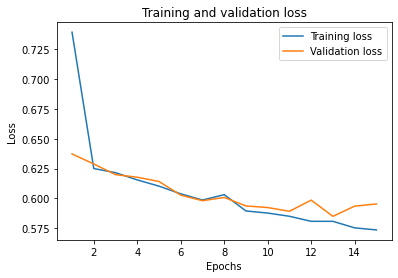

In [33]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

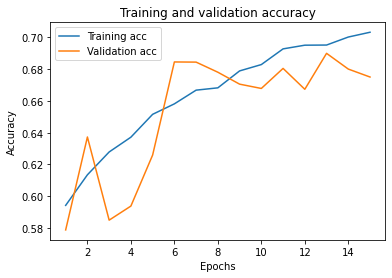

In [34]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

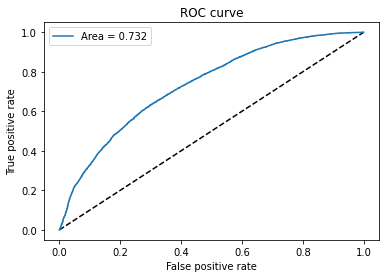

In [37]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Experiment 2, second DNN

This model is the same as in Experiment 1, but with an additional hidden layer. First hidden layer has 200 nodes, second hidden layer has 100 nodes.

##Build and compile the model

In [38]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(96, 96, 3)))
model.add(layers.Dense(200, activation='sigmoid'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 27648)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               5529800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 5,530,001
Trainable params: 5,530,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [40]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=20,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/20
54400/54400 [==============================] - 18s 339us/step - loss: 0.7951 - accuracy: 0.5853 - val_loss: 0.6741 - val_accuracy: 0.5978
Epoch 2/20
54400/54400 [==============================] - 18s 332us/step - loss: 0.6792 - accuracy: 0.5876 - val_loss: 0.6749 - val_accuracy: 0.5978
Epoch 3/20
54400/54400 [==============================] - 18s 334us/step - loss: 0.6778 - accuracy: 0.5930 - val_loss: 0.6740 - val_accuracy: 0.5978
Epoch 4/20
54400/54400 [==============================] - 18s 332us/step - loss: 0.6772 - accuracy: 0.5942 - val_loss: 0.6745 - val_accuracy: 0.5978
Epoch 5/20
54400/54400 [==============================] - 18s 336us/step - loss: 0.6764 - accuracy: 0.5943 - val_loss: 0.6742 - val_accuracy: 0.5978
Epoch 6/20
54400/54400 [==============================] - 18s 333us/step - loss: 0.6767 - accuracy: 0.5943 - val_loss: 0.6758 - val_accuracy: 0.5978
Epoch 7/20
54400/54400 [==============================] -

In [41]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

362.900713

##Test the model

In [42]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 4s 249us/step


(0.6777317978143692, 0.5913749933242798)

In [43]:
test_time = test_rt.process_time
test_time # in seconds

3.992475

###Add training and test statistics to results dataframe

In [44]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (200 sigmoid dropout)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
19,DNN (200 sigmoid dropout),0.674662,0.597812,0.676179,0.594301,0.677732,0.591375,362.900713,3.992475


In [45]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),0.595367,0.675000,0.573642,0.703162,0.598370,0.678813,248.419858,3.794679
1,DNN (200 sigmoid dropout),0.674662,0.597812,0.676179,0.594301,0.677732,0.591375,362.900713,3.992475


### Plotting the performance 


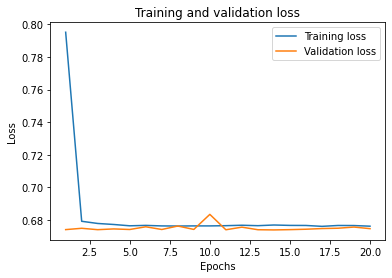

In [46]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

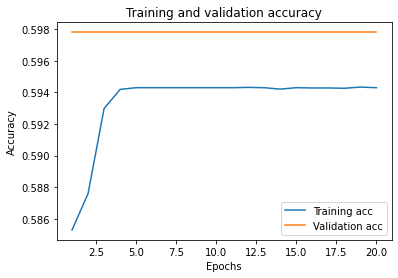

In [47]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

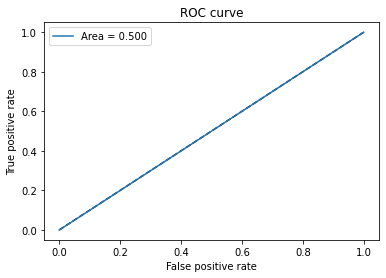

In [50]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Experiment 3: CNN with 2 convolutional layers

In [51]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               7930112   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [53]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 45s 832us/step - loss: 0.6232 - accuracy: 0.6386 - val_loss: 0.6116 - val_accuracy: 0.6796
Epoch 2/15
54400/54400 [==============================] - 40s 744us/step - loss: 0.5004 - accuracy: 0.7581 - val_loss: 0.4471 - val_accuracy: 0.7974
Epoch 3/15
54400/54400 [==============================] - 40s 742us/step - loss: 0.4102 - accuracy: 0.8158 - val_loss: 0.4051 - val_accuracy: 0.8210
Epoch 4/15
54400/54400 [==============================] - 40s 744us/step - loss: 0.3612 - accuracy: 0.8419 - val_loss: 0.3974 - val_accuracy: 0.8233
Epoch 5/15
54400/54400 [==============================] - 40s 742us/step - loss: 0.3054 - accuracy: 0.8711 - val_loss: 0.4770 - val_accuracy: 0.7848
Epoch 6/15
54400/54400 [==============================] - 41s 745us/step - loss: 0.2340 - accuracy: 0.9054 - val_loss: 0.4425 - val_accuracy: 0.8255
Epoch 7/15
54400/54400 [==============================] -

In [54]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

610.42857

##Test the model

In [55]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 8s 475us/step


(1.249494971781969, 0.8113124966621399)

In [56]:
test_time = test_rt.process_time
test_time # in seconds

7.595199

###Add training and test statistics to results dataframe

In [57]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,CNN (2 layers),1.301419,0.808125,0.007358,0.998254,1.249495,0.811312,610.42857,7.595199


In [58]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),0.595367,0.675000,0.573642,0.703162,0.598370,0.678813,248.419858,3.794679
1,DNN (200 sigmoid dropout),0.674662,0.597812,0.676179,0.594301,0.677732,0.591375,362.900713,3.992475
2,CNN (2 layers),1.301419,0.808125,0.007358,0.998254,1.249495,0.811312,610.428570,7.595199


### Plotting the performance 


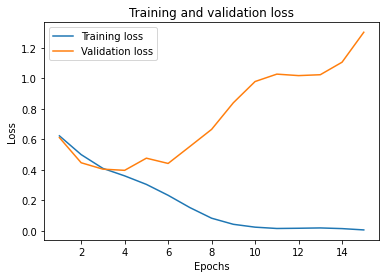

In [59]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

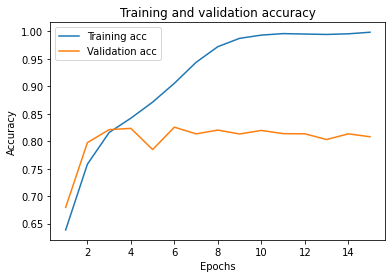

In [60]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

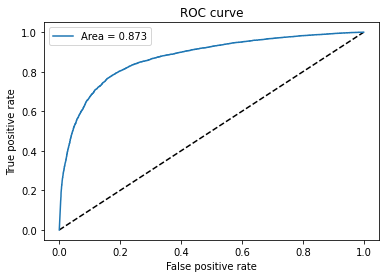

In [63]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Experiment 4: CNN with 2 convolutional layers, dropout

In [64]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30976)            

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [66]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 45s 822us/step - loss: 0.5275 - accuracy: 0.7421 - val_loss: 0.4819 - val_accuracy: 0.7725
Epoch 2/15
54400/54400 [==============================] - 44s 815us/step - loss: 0.4402 - accuracy: 0.8017 - val_loss: 0.4212 - val_accuracy: 0.8192
Epoch 3/15
54400/54400 [==============================] - 44s 813us/step - loss: 0.4008 - accuracy: 0.8250 - val_loss: 0.4093 - val_accuracy: 0.8172
Epoch 4/15
54400/54400 [==============================] - 44s 813us/step - loss: 0.3742 - accuracy: 0.8399 - val_loss: 0.4200 - val_accuracy: 0.8205
Epoch 5/15
54400/54400 [==============================] - 44s 813us/step - loss: 0.3502 - accuracy: 0.8492 - val_loss: 0.3630 - val_accuracy: 0.8426
Epoch 6/15
54400/54400 [==============================] - 44s 813us/step - loss: 0.3227 - accuracy: 0.8626 - val_loss: 0.3919 - val_accuracy: 0.8347
Epoch 7/15
54400/54400 [==============================] -

In [67]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

663.120327

##Test the model

In [68]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 8s 476us/step


(0.5624494726508856, 0.8470625281333923)

In [69]:
test_time = test_rt.process_time
test_time # in seconds

7.613946

###Add training and test statistics to results dataframe

In [70]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers, D)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,"CNN (2 layers, D)",0.605155,0.839688,0.07998,0.972004,0.562449,0.847063,663.120327,7.613946


In [71]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),0.595367,0.675000,0.573642,0.703162,0.598370,0.678813,248.419858,3.794679
1,DNN (200 sigmoid dropout),0.674662,0.597812,0.676179,0.594301,0.677732,0.591375,362.900713,3.992475
2,CNN (2 layers),1.301419,0.808125,0.007358,0.998254,1.249495,0.811312,610.428570,7.595199
3,"CNN (2 layers, D)",0.605155,0.839688,0.079980,0.972004,0.562449,0.847063,663.120327,7.613946


### Plotting the performance 


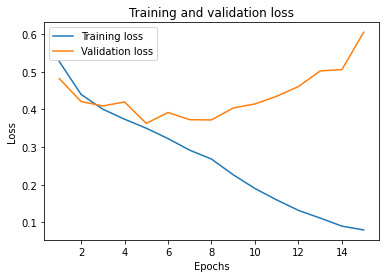

In [72]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

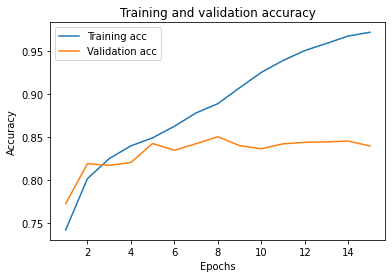

In [73]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

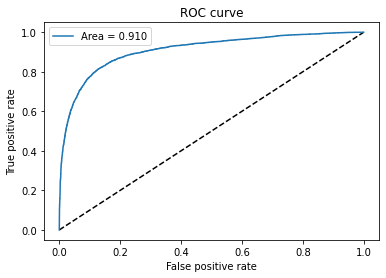

In [76]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Pre-trained Network

###Instantiate the model

Do not use dropout initially

In [77]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (96, 96, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 15,894,849
Trainable params: 15,894,849
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 151s 3ms/step - loss: 0.3971 - accuracy: 0.8311 - val_loss: 0.3199 - val_accuracy: 0.8630
Epoch 2/15
54400/54400 [==============================] - 148s 3ms/step - loss: 0.2902 - accuracy: 0.8790 - val_loss: 0.2671 - val_accuracy: 0.8885
Epoch 3/15
54400/54400 [==============================] - 148s 3ms/step - loss: 0.2477 - accuracy: 0.8994 - val_loss: 0.2615 - val_accuracy: 0.8983
Epoch 4/15
54400/54400 [==============================] - 149s 3ms/step - loss: 0.2227 - accuracy: 0.9121 - val_loss: 0.2627 - val_accuracy: 0.8964
Epoch 5/15
54400/54400 [==============================] - 148s 3ms/step - loss: 0.1944 - accuracy: 0.9239 - val_loss: 0.2560 - val_accuracy: 0.8994
Epoch 6/15
54400/54400 [==============================] - 148s 3ms/step - loss: 0.1727 - accuracy: 0.9331 - val_loss: 0.2630 - val_accuracy: 0.8996
Epoch 7/15
54400/54400 [==============================] - 148s 

In [445]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

79.2981

###Test the model

In [446]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 1s 637us/step


(0.6822039012908936, 0.5799999833106995)

In [447]:
test_time = test_rt.process_time
test_time # in seconds

1.27461

###Add training and test statistics to results dataframe

In [448]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,"VGG16, 3",0.670243,0.606667,0.668571,0.610588,0.682204,0.58,79.2981,1.27461


In [449]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),97.838210,0.396667,33.904952,0.662794,95.340197,0.4280,8.870533,0.234464
1,DNN (2 layers),4.349738,0.585833,4.280782,0.652647,4.540591,0.5770,10.395900,0.212265
2,CNN (2 layers),1.869428,0.718333,0.036994,0.990588,1.904011,0.7045,23.211717,0.317783
3,"CNN (2 layers, D)",1.306876,0.474167,0.457658,0.790441,1.246114,0.5070,26.260452,0.338400
4,"VGG16, 3",0.670223,0.606667,0.668946,0.610588,0.681980,0.5800,78.560002,1.587769
5,"VGG16, 3",0.670243,0.606667,0.668571,0.610588,0.682204,0.5800,79.298100,1.274610


### Plotting the performance 


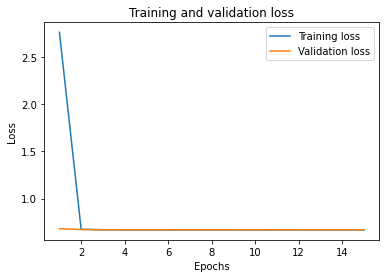

In [450]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

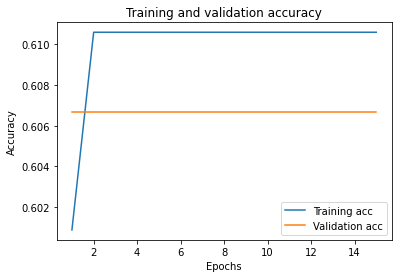

In [451]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

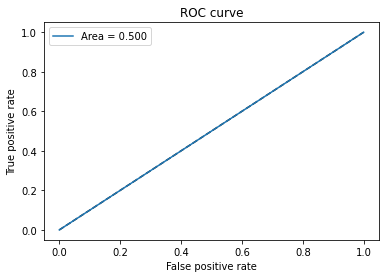

In [454]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam80k.csv')
files.download('PCam80k.csv')

##VGG16 with Dropout

In [455]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (96, 96, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_23 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               1179904   
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 257       
Total params: 15,894,849
Trainable params: 15,894,849
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [458]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 6800 samples, validate on 1200 samples
Epoch 1/15
6800/6800 [==============================] - 6s 828us/step - loss: 2.1972 - accuracy: 0.5896 - val_loss: 0.6860 - val_accuracy: 0.6067
Epoch 2/15
6800/6800 [==============================] - 5s 778us/step - loss: 0.6804 - accuracy: 0.6106 - val_loss: 0.6762 - val_accuracy: 0.6067
Epoch 3/15
6800/6800 [==============================] - 5s 782us/step - loss: 0.6733 - accuracy: 0.6106 - val_loss: 0.6722 - val_accuracy: 0.6067
Epoch 4/15
6800/6800 [==============================] - 5s 782us/step - loss: 0.6701 - accuracy: 0.6106 - val_loss: 0.6707 - val_accuracy: 0.6067
Epoch 5/15
6800/6800 [==============================] - 5s 783us/step - loss: 0.6691 - accuracy: 0.6106 - val_loss: 0.6703 - val_accuracy: 0.6067
Epoch 6/15
6800/6800 [==============================] - 5s 782us/step - loss: 0.6682 - accuracy: 0.6106 - val_loss: 0.6702 - val_accuracy: 0.6067
Epoch 7/15
6800/6800 [==============================] - 5s 784us/step - loss

In [459]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

80.128857

###Test the model

In [460]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 1s 657us/step


(0.6821512746810913, 0.5799999833106995)

In [461]:
test_time = test_rt.process_time
test_time # in seconds

1.315191

###Add training and test statistics to results dataframe

In [462]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3 thawed, D') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,"VGG16, 3",0.670237,0.606667,0.668797,0.610588,0.682151,0.58,80.128857,1.315191


In [463]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),97.838210,0.396667,33.904952,0.662794,95.340197,0.4280,8.870533,0.234464
1,DNN (2 layers),4.349738,0.585833,4.280782,0.652647,4.540591,0.5770,10.395900,0.212265
2,CNN (2 layers),1.869428,0.718333,0.036994,0.990588,1.904011,0.7045,23.211717,0.317783
3,"CNN (2 layers, D)",1.306876,0.474167,0.457658,0.790441,1.246114,0.5070,26.260452,0.338400
4,"VGG16, 3",0.670223,0.606667,0.668946,0.610588,0.681980,0.5800,78.560002,1.587769
5,"VGG16, 3",0.670243,0.606667,0.668571,0.610588,0.682204,0.5800,79.298100,1.274610
6,"VGG16, 3",0.670237,0.606667,0.668797,0.610588,0.682151,0.5800,80.128857,1.315191


### Plotting the performance 


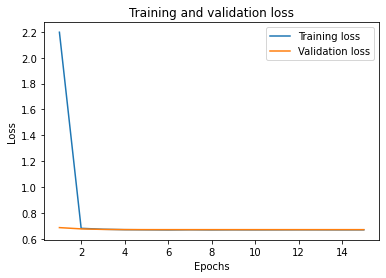

In [464]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

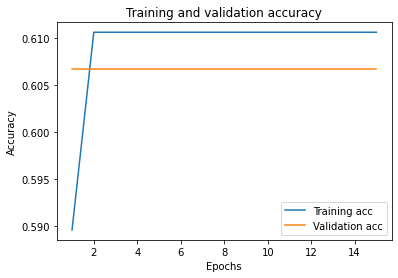

In [465]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

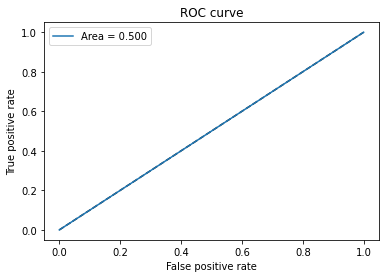

In [468]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##VGG16 unfreeze 6 convolutional layers (block 4 and block 5)

In [469]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (96, 96, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_24 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 256)               1179904   
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 257       
Total params: 15,894,849
Trainable params: 15,894,849
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [472]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 6800 samples, validate on 1200 samples
Epoch 1/15
6800/6800 [==============================] - 7s 1ms/step - loss: 11.1120 - accuracy: 0.5759 - val_loss: 0.6878 - val_accuracy: 0.6067
Epoch 2/15
6800/6800 [==============================] - 6s 950us/step - loss: 0.8154 - accuracy: 0.6054 - val_loss: 0.6784 - val_accuracy: 0.6067
Epoch 3/15
6800/6800 [==============================] - 6s 951us/step - loss: 0.6738 - accuracy: 0.6106 - val_loss: 0.6721 - val_accuracy: 0.6067
Epoch 4/15
6800/6800 [==============================] - 6s 948us/step - loss: 0.6699 - accuracy: 0.6106 - val_loss: 0.6705 - val_accuracy: 0.6067
Epoch 5/15
6800/6800 [==============================] - 6s 944us/step - loss: 0.6688 - accuracy: 0.6106 - val_loss: 0.6702 - val_accuracy: 0.6067
Epoch 6/15
6800/6800 [==============================] - 6s 943us/step - loss: 0.6686 - accuracy: 0.6106 - val_loss: 0.6702 - val_accuracy: 0.6067
Epoch 7/15
6800/6800 [==============================] - 6s 947us/step - loss:

In [473]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

96.957854

###Test the model

In [474]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

2000/2000 [==============================] - 1s 630us/step


(0.6823359498977661, 0.5799999833106995)

In [475]:
test_time = test_rt.process_time
test_time # in seconds

1.261503

###Add training and test statistics to results dataframe

In [476]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,"VGG16, 3",0.670261,0.606667,0.668581,0.610588,0.682336,0.58,96.957854,1.261503


In [477]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),97.838210,0.396667,33.904952,0.662794,95.340197,0.4280,8.870533,0.234464
1,DNN (2 layers),4.349738,0.585833,4.280782,0.652647,4.540591,0.5770,10.395900,0.212265
2,CNN (2 layers),1.869428,0.718333,0.036994,0.990588,1.904011,0.7045,23.211717,0.317783
3,"CNN (2 layers, D)",1.306876,0.474167,0.457658,0.790441,1.246114,0.5070,26.260452,0.338400
4,"VGG16, 3",0.670223,0.606667,0.668946,0.610588,0.681980,0.5800,78.560002,1.587769
5,"VGG16, 3",0.670243,0.606667,0.668571,0.610588,0.682204,0.5800,79.298100,1.274610
6,"VGG16, 3",0.670237,0.606667,0.668797,0.610588,0.682151,0.5800,80.128857,1.315191
7,"VGG16, 3",0.670261,0.606667,0.668581,0.610588,0.682336,0.5800,96.957854,1.261503


### Plotting the performance 


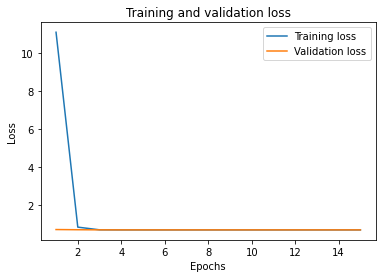

In [478]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

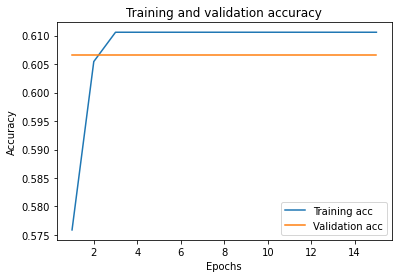

In [479]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

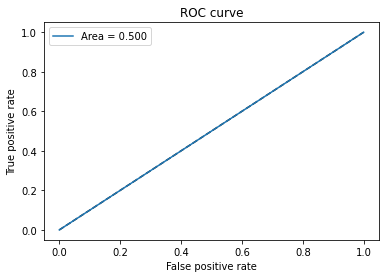

In [482]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()